# Drive Portfolio Optimization

Implementation of Bayesian reliability prediction, Monte‑Carlo simulation and mean/CVaR portfolio optimisation for external storage devices.

## Load daily CSV files

In [1]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.optimize import minimize
import glob
import pandas as pd
from pathlib import Path

In [ ]:
DATA_PATH = Path('/Users/cobeq/Downloads/data_Q4_2024') # dataset downloaded from https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q4_2024.zip
files = sorted(DATA_PATH.glob('*.csv'))[-10:]
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
print(f'Loaded {len(df):,} rows from {len(files)} daily files')
df.head()


/var/folders/8r/nncxr9rj3530t_n2qx479mv00000gn/T/ipykernel_84786/4278096437.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
/var/folders/8r/nncxr9rj3530t_n2qx479mv00000gn/T/ipykernel_84786/4278096437.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
/var/folders/8r/nncxr9rj3530t_n2qx479mv00000gn/T/ipykernel_84786/4278096437.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
/var/folders/8r/nncxr9rj3530t_n2qx479mv00000gn/T/ipykernel_84786/4278096437.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f) for f in files], ignore_index=Tr

Loaded 3,051,535 rows from 10 daily files


,date,serial_number,model,capacity_bytes,failure,datacenter,cluster_id,vault_id,pod_id,pod_slot_num,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2024-12-22,S2ZYJ9GGB01000,ST500LM012 HN,500107862016,0,sac0,0,1028,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-12-22,VKH7A84X,HGST HUH728080ALE600,8001563222016,0,sac0,0,1028,0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-12-22,ZA106RPJ,ST8000DM002,8001563222016,0,sac0,0,1028,0,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-12-22,ZA106YX1,ST8000DM002,8001563222016,0,sac0,0,1028,0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-12-22,ZA106Z5M,ST8000DM002,8001563222016,0,sac0,0,1028,0,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Сводная информация
display(df.info())

# Краткая статистика по числовым признакам
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3051535 entries, 0 to 3051534
Columns: 197 entries, date to smart_255_raw
dtypes: bool(1), float64(187), int64(5), object(4)
memory usage: 4.5+ GB


None

,capacity_bytes,failure,cluster_id,vault_id,pod_id,pod_slot_num,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
count,3.051535e+06,3.051535e+06,3.051535e+06,3.051535e+06,3.051535e+06,3.010610e+06,3.043413e+06,3.043413e+06,1.957740e+06,1.957740e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,2100.000000,2100.0,0.0,0.0
mean,1.448410e+13,2.261157e-05,1.386397e+01,1.387945e+03,9.501762e+00,2.862430e+01,9.306733e+01,4.240120e+07,1.170493e+02,3.694481e+01,...,NaN,NaN,NaN,NaN,NaN,NaN,103.333333,0.0,NaN,NaN
std,4.039653e+12,4.755110e-03,1.971153e+01,5.298638e+02,5.765868e+00,1.732247e+01,1.011550e+01,7.182913e+07,2.350316e+01,4.235253e+01,...,NaN,NaN,NaN,NaN,NaN,NaN,17.954825,0.0,NaN,NaN
min,-1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+03,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0.0,NaN,NaN
25%,1.200014e+13,0.000000e+00,0.000000e+00,1.068000e+03,5.000000e+00,1.400000e+01,8.300000e+01,0.000000e+00,1.000000e+02,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0.0,NaN,NaN
50%,1.400052e+13,0.000000e+00,0.000000e+00,1.132000e+03,1.000000e+01,2.800000e+01,1.000000e+02,0.000000e+00,1.000000e+02,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0.0,NaN,NaN
75%,1.600090e+13,0.000000e+00,3.100000e+01,1.413000e+03,1.500000e+01,4.400000e+01,1.000000e+02,6.836793e+07,1.360000e+02,9.200000e+01,...,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0.0,NaN,NaN
max,2.400028e+13,1.000000e+00,6.000000e+01,3.013000e+03,1.900000e+01,5.900000e+01,2.000000e+02,4.294967e+09,2.520000e+02,2.039000e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,200.000000,0.0,NaN,NaN


### Пропуски

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from lifelines import KaplanMeierFitter, CoxPHFitter


In [5]:

# plt.rcParams['figure.figsize'] = (10, 6)
# pd.options.display.max_columns = 200
# msno.matrix(df.sample(min(1000, len(df))))
# plt.title('Пропуски в случайной выборке');
# plt.show()

## Подготовка данных для Survival‑моделей

In [4]:
df=df[df["smart_9_raw"].notna()]

In [5]:
# Для каждой серийной номерной единицы определяем начало и конец наблюдений,
# и был ли отказ (failure == 1)
agg = (
    df.groupby('serial_number')
      .agg(duration=('smart_9_raw', 'max'),
           event=('failure', 'max'))
)

Text(0.5, 1.0, 'Доля отказов (failure == 1) в выборке')

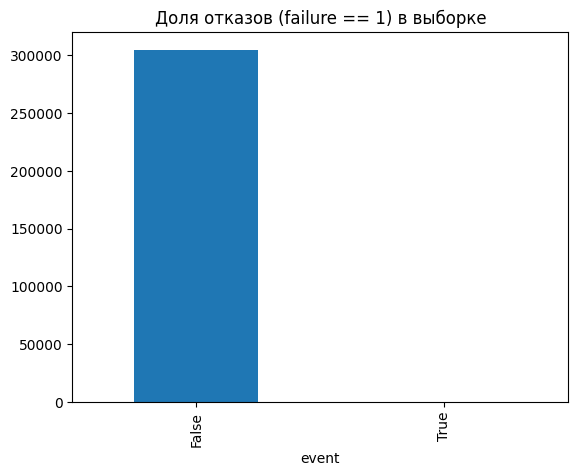

In [7]:
import matplotlib.pyplot as plt
agg["duration_days"] = agg["duration"] / 24
agg["event"] = agg["event"].astype(bool)
agg["event"].value_counts().plot.bar()
plt.title('Доля отказов (failure == 1) в выборке')

In [8]:
agg.value_counts("event")

event
False    304855
True         69
Name: count, dtype: int64

### Распределение длительностей жизни дисков

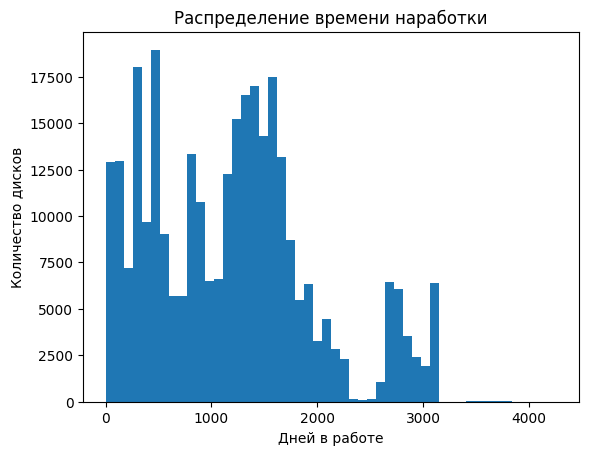

In [9]:
plt.hist(agg['duration_days'], bins=50)
plt.xlabel('Дней в работе')
plt.ylabel('Количество дисков')
plt.title('Распределение времени наработки');
plt.show()

## Общая кривая Kaplan–Meier

In [11]:
from matplotlib import style
style.use('classic')

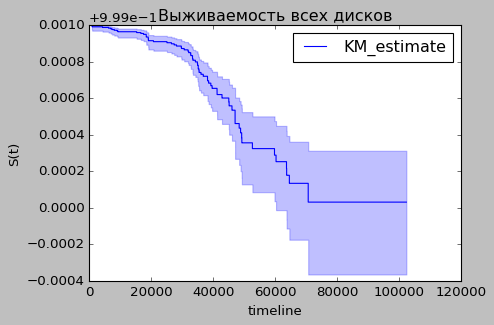

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
kmf = KaplanMeierFitter()

kmf.fit(durations=agg['duration'],
        event_observed=agg['event'])

kmf.plot_survival_function(ax=ax)
ax.set_ylabel('S(t)')
ax.set_title('Выживаемость всех дисков')
plt.show()

## Kaplan–Meier по моделям (топ‑5)

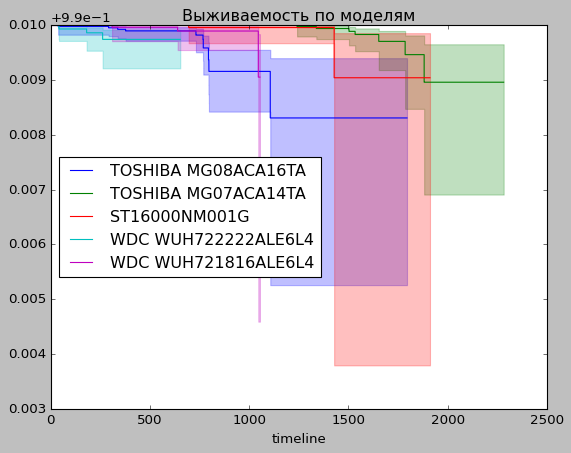

In [19]:
top_models = df['model'].value_counts().head(5).index
fig, ax = plt.subplots()
for model in top_models:
    subset = agg.join(df[['serial_number', 'model']].drop_duplicates().set_index('serial_number'))
    subset = subset[subset['model'] == model]
    kmf.fit(subset['duration_days'], subset['event'], label=model)
    kmf.plot_survival_function(ax=ax)
plt.title('Выживаемость по моделям');
plt.ticklabel_format(style='plain', axis='y')  # обычный формат чисел
plt.show()

## Корреляция SMART‑метрик и отказов

In [ ]:
# # Выберем только SMART поля (normalized/raw) и failure
# smart_cols = [col for col in df.columns if col.startswith('smart_')]
# corr = df[smart_cols + ['failure']].corr()['failure'].sort_values(ascending=False)
# display(corr.head(20))

# # Тепловая карта по абсолютным корреляциям
# plt.figure(figsize=(12,8))
# sns.heatmap(df[smart_cols].corr(), cmap='coolwarm', center=0, cbar_kws={'shrink': .5})
# plt.title('Корреляции между SMART‑показателями');

: 

## Cox Proportional Hazards Model

In [32]:
# # Пример базового CoxPH: берём duration, event и несколько фичей
# cox_df = agg[['duration_days', 'event']].copy()

# # Добавляем capacity и одну из SMART метрик (например, smart_5_raw — секторные ошибки)
# latest_features = (
#     df.groupby('serial_number')
#       .tail(1)
#       .set_index('serial_number')
# )
# cox_df['capacity_bytes'] = latest_features['capacity_bytes']
# if 'smart_5_raw' in latest_features.columns:
#     cox_df['smart_5_raw'] = latest_features['smart_5_raw']

# cox = CoxPHFitter()
# cox_df = cox_df.dropna() 
# cox.fit(cox_df, duration_col='duration_days', event_col='event')
# cox.print_summary()

## Feature engineering

In [11]:
SMART_COLS = [c for c in df.columns if c.startswith('smart_') and c.endswith('_normalized')]
SMART_COLS += ['smart_9_raw']
X_feat = df[SMART_COLS]
y_fail = df['failure'].astype(int)


## Reliability model
For demonstration we train a CatBoostClassifier to predict failure probability within horizon **H** (adjust `FAIL_HORIZON_DAYS`). Production version should output a full time‑to‑failure distribution.

In [12]:
from catboost import CatBoostClassifier

FAIL_HORIZON_DAYS = 30

model = CatBoostClassifier(iterations=300,
                           depth=6,
                           learning_rate=0.1,
                           loss_function='Logloss',
                           posterior_sampling=True,
                           verbose=False)
model.fit(X_feat, y_fail)

df['p_fail'] = model.predict_proba(X_feat)[:,1]
df['p_fail'].describe()


count    3.046463e+06
mean     2.271686e-05
std      1.290490e-03
min      5.225068e-08
25%      3.514873e-06
50%      9.714840e-06
75%      2.390729e-05
max      8.905710e-01
Name: p_fail, dtype: float64

In [13]:
res = model.virtual_ensembles_predict(X_feat, virtual_ensembles_count=100, prediction_type="VirtEnsembles")

In [14]:
raw = res.squeeze(-1)
proba_ve = 1.0 / (1.0 + np.exp(-raw))   # (N, 100)
p_mean = proba_ve.mean(axis=1)          # (N,)
p_var  = proba_ve.var(axis=1)           # (N,)

In [21]:
import numpy as np
import pandas as pd

from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

import matplotlib.pyplot as plt

REVENUE_PER_TB = 1.0           # $ / 30 дней                 (меняйте)
LOSS_FN        = 15.0          # штраф за false-negative     (диск не заменён → отказ)
LOSS_FP        =  0.5          # штраф за false-positive     (заменили зря)

CAPACITY_TB = df.capacity_bytes.values / 1e12       # (N,)

# ─────────────────────────────────  3.  Параметры Beta(α,β)
# избегаем деления на 0:
eps   = 1e-12
ratio = np.clip(p_mean*(1-p_mean)/np.maximum(p_var, eps) - 1, 0, None)
alpha = p_mean  * ratio + eps
beta  = (1-p_mean) * ratio + eps

# ─────────────────────────────────  4.  Симулятор прибыли
def simulate_profit(threshold, i_buf,  n_rep=20000, α=alpha, β=beta):
    """
    threshold : float ∈ [0,1] – порог, выше которого диск заменяем
    n_rep     :  Monte-Carlo итерации
    return    :  profits shape (n_rep,)
    """
    # [0,1] -> [10, 100]
    batch_size = int(np.clip(i_buf, 10, 100))
    N = batch_size
    index = np.random.choice(len(p_mean), N, replace=False)  # случайные индексы
    alp = α[index]  # (N,)
    bet = β[index]  # (N,)

    # 2) генерируем n_rep×N вероятностей отказа (Beta) и исходы (Bernoulli)
    p_fail   = np.random.beta(alp, bet, size=(n_rep, N))
    # определяем плановую замену по real_failure и порогу
    replace = (p_fail >= threshold)  # bool, (n_rep, N)
    real_failed = df["failure"][index]
    stacked_real_failed = np.tile(np.array(real_failed), (n_rep, 1))  # (n_rep, N)
    

    # 3) прибыль:                             --------------- пояснение
    #    диск неисправен → 0 TB-доход + штраф FN, если не заменили
    #    диск исправен  → доход за TB         + штраф FP,  если заменили зря
    revenue_tb = CAPACITY_TB[index] * REVENUE_PER_TB      # (N,)

    keep_good  = (~replace)[None, :][0] & (~stacked_real_failed)   # всё хорошо, дохoд есть
    false_pos  =  replace[None, :][0] & (~stacked_real_failed)     # заменили зря
    false_neg  = (~replace)[None, :][0] &   stacked_real_failed    # не заменили → отказ

    profit = (
        keep_good * revenue_tb                # положительный поток
        - false_pos * LOSS_FP                 # небольшой штраф
        - false_neg * LOSS_FN                 # крупный штраф
    ).sum(axis=1).mean()                             # по дискам

    ubytki = (
        false_pos * LOSS_FP          
        + false_neg * LOSS_FN        
    ).sum(axis=1)                            
    cutoff = np.quantile(ubytki, 1-α_cvar)
    cvar  = ubytki[ubytki <= cutoff].mean()

    return profit, cvar                             # (n_rep,)

# ─────────────────────────────────  5.  Задача pymoo
α_cvar = 0.95                       # уровень CVaR



In [22]:
class DiskPolicyProblem(Problem):
    def __init__(self):
        super().__init__(n_var=2,      # единственная переменная — threshold, i_buf
                         n_obj=2,      # [-E, CVaR] → minimизация
                         xl=np.array([0.0, 0.0]),
                         xu=np.array([1.0, 1.0]))

    def _evaluate(self, X, out, **kwargs):
        F = np.zeros((len(X), 2))
        for i, (thr, i_buf) in enumerate(X):
            mean, cvar  = simulate_profit(threshold=thr, i_buf=i_buf)
            F[i, 0] = -mean           # хотим ↑ → меняем знак
            F[i, 1] =  cvar           # хотим ↓
        out["F"] = F

# ─────────────────────────────────  6.  NSGA-II
problem = DiskPolicyProblem()
algo    = NSGA2(pop_size=64)
result  = minimize(problem,
                   algo,
                   ("n_gen", 10),
                   seed=42,
                   verbose=True, save_history=True)

# ─────────────────────────────────  7.  Фронт Парето
pareto_thresholds = result.X.ravel()           # оптимальные пороги
pareto_F          = result.F                   # [-E, CVaR]

front = np.column_stack([-pareto_F[:,0],       # восстановим E
                          pareto_F[:,1]])      # CVaR

# ─────────────────────────────────  8.  Визуализация
plt.scatter(front[:,0], front[:,1])
plt.xlabel("Средний доход за 30 дней, $")
plt.ylabel("CVaR₀․₉₅ (ниже — лучше), $")
plt.title("Парето-фронт: доход ↔ риск")
plt.grid(True)
plt.show()


KeyError: '[216720] not in index'

## Monte‑Carlo profit simulator

In [ ]:
import numpy as np

# Example economic priors by disk model (replace with real numbers)
# indexed by model_id 0..2
N_DISK_MODELS = len(df['model'].unique())//2
# PRICE_SIGMA = np.array([50, 60, 80])
# CAPACITY = np.array([4, 8, 16]) * 1024**3     # bytes
REV_PER_GB_YEAR = 0.025                       # revenue
REV_PER_TB_YEAR = 25                       # revenue
HORIZON_YEARS = 3
ALPHA = 0.05

weights = np.array([0.25, 0.60, 0.15])
mus     = np.array([4.174, 4.499, 5.193])
sigmas  = np.array([0.25, 0.30, 0.25])

def sample_external_drive_price(size=1):
    k = np.random.choice(len(weights), p=weights, size=size)
    return np.random.lognormal(mean=mus[k], sigma=sigmas[k])

capacity_pmf = {
    1: (np.array([1, 2, 4]),       np.array([0.40, 0.40, 0.20])),
    2: (np.array([0.5, 1, 2, 4]),  np.array([0.25, 0.35, 0.30, 0.10])),
    3: (np.array([2, 4, 8]),       np.array([0.40, 0.40, 0.20])),
}

def sample_capacity_tb(segment_k: int, size=1):
    """Возвращает массив ёмкостей в ТБ для выбранного ценового сегмента k."""
    caps, probs = capacity_pmf[segment_k]
    return np.random.choice(caps, p=probs, size=size)

CAPACITY = sample_capacity_tb(2, N_DISK_MODELS)

PENALTY = 2000             # штраф за каждый диск, сломавшийся < 1 год
FAIL_WINDOW_DAYS = 365

# shape (k) и scale (λ)
k_e   = np.array([0.7, 0.6, 0.7])
lam_e = np.array([0.30, 0.25, 0.30])     # early-fail
k_w   = np.array([1.5, 1.3, 1.4])
lam_w = np.array([4.0, 3.5, 5.5])        # wear-out
q     = np.array([0.08, 0.12, 0.05])     # early-fail share

def sample_ttf_years(segment_k: int, size=1):
    """Возвращает массив TTF (лет) для выбранного ценового сегмента k=1..3."""
    idx = segment_k - 1
    early = np.random.rand(size) < q[idx]
    ttf   = np.empty(size)
    # ранние отказы
    n_e = early.sum()
    if n_e:
        ttf[early] = lam_e[idx] * np.random.weibull(k_e[idx], n_e)
    # нормальный износ
    n_w = size - n_e
    if n_w:
        ttf[~early] = lam_w[idx] * np.random.weibull(k_w[idx], n_w)
    return ttf


def simulate_portfolio(x, n_sim=3000, rng=None):
    """Return (-mean_profit, CVaR_alpha) for integer vector x of disk counts."""
    rng = np.random.default_rng(rng)
    profits = []
    for _ in range(n_sim):
        prices = sample_external_drive_price(N_DISK_MODELS)
        cost = (prices * x).sum()
        # Sample failures independently using learned probabilities
        n_disks = int(x.sum())
        ttf = sample_ttf_years(2, n_disks)          
        early_fail_penalty = PENALTY * (ttf < FAIL_WINDOW_DAYS).sum()

        # fail_samples = rng.random(n_disks) < df['p_fail'].sample(n_disks, replace=True).values
        # capacity_alive = ((~fail_samples).astype(int) * np.repeat(CAPACITY, x)).sum()
        # revenue = capacity_alive / 1024**3 * REV_PER_GB_YEAR * HORIZON_YEARS
        revenue = np.where(ttf > HORIZON_YEARS,
                           CAPACITY.repeat(x) * REV_PER_TB_YEAR * HORIZON_YEARS,
                           CAPACITY.repeat(x) * REV_PER_TB_YEAR * ttf
                           ).sum()
        profits.append(revenue - cost - early_fail_penalty)
    profits = np.asarray(profits)
    mean_p = profits.mean()
    worst = np.partition(profits, int(np.ceil(ALPHA * n_sim)))[:int(np.ceil(ALPHA * n_sim))]
    cvar = worst.mean()
    return -mean_p, cvar


## Optimization with pymoo (NSGA‑II)

In [10]:
CAPACITY

array([2. , 2. , 0.5, 2. , 4. , 0.5, 0.5, 2. , 4. , 1. , 2. , 2. , 1. ,
       0.5, 1. , 0.5, 1. , 1. , 2. , 1. , 2. , 0.5, 0.5, 0.5, 1. , 1. ,
       2. , 1. , 0.5, 1. , 4. , 0.5, 0.5, 1. , 1. , 4. , 1. ])

In [ ]:


TARGET_CAPACITY = 10      # GB
MAX_UNITS = 100

class PortfolioProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=N_DISK_MODELS,
                         xl=np.zeros(N_DISK_MODELS),
                         xu=np.full(N_DISK_MODELS, MAX_UNITS),
                         vtype=int,
                         n_obj=2,
                         n_constr=1)

    def _evaluate(self, x, out, *args, **kwargs):
        f1, f2 = simulate_portfolio(np.asarray(x, dtype=int), n_sim=2000)
        out['F'] = [f1, f2]             # minimise
        cap_deficit = TARGET_CAPACITY - (x * CAPACITY).sum()
        out['G'] = [cap_deficit]        # ≤0 means feasible

problem = PortfolioProblem()

algorithm = NSGA2(pop_size=40,
                  sampling=IntegerRandomSampling(),
                  crossover=SBX(prob=0.9, eta=15),
                  mutation=PM(eta=20),
                  eliminate_duplicates=True)

res = minimize(problem,
               algorithm,
               ('n_gen', 40),
               seed=42,
               verbose=True)
print(f'Finished; {len(res.X)} Pareto‑optimal portfolios found')



Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       40 |     39 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |       80 |     40 |  0.000000E+00 |  0.000000E+00 |  0.0796419826 |         ideal
     3 |      120 |     40 |  0.000000E+00 |  0.000000E+00 |  0.0207464444 |         ideal
     4 |      160 |     40 |  0.000000E+00 |  0.000000E+00 |  0.1142059076 |         ideal
     5 |      200 |     40 |  0.000000E+00 |  0.000000E+00 |  0.0060396147 |             f
     6 |      240 |     40 |  0.000000E+00 |  0.000000E+00 |  0.0057611552 |             f
     7 |      280 |     40 |  0.000000E+00 |  0.000000E+00 |  0.0474670783 |         ideal
     8 |      320 |     40 |  0.000000E+00 |  0.000000E+00 |  0.0

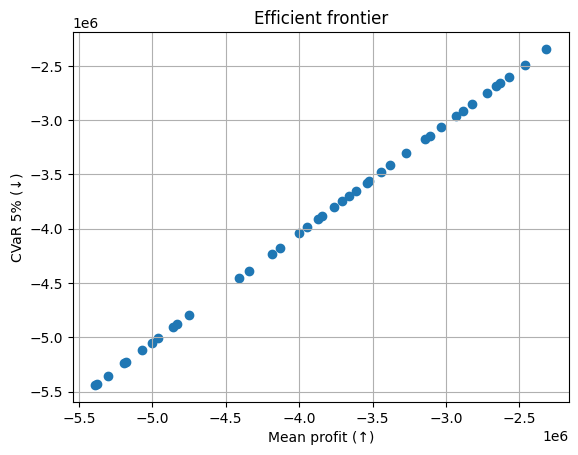

In [12]:
import matplotlib.pyplot as plt

plt.scatter(-res.F[:,0], res.F[:,1])
plt.xlabel('Mean profit (↑)')
plt.ylabel(f'CVaR {ALPHA:.0%} (↓)')
plt.title('Efficient frontier')
plt.grid(True)
plt.show()


### Inspect candidate portfolios

In [13]:
for x, (mean_neg, cvar) in sorted(zip(res.X, res.F), key=lambda t: t[1][1]):
    print(f'x={x}  mean={-mean_neg:,.2f}  CVaR={cvar:,.2f}')


x=[89.56422115 51.9937883  86.95203881 44.22069771 93.40160634 52.95680827
 96.82507372 87.95850396 95.88460192 88.1886691  91.33105321 61.4303944
 94.11607578 92.697109   59.51983109 78.7007308  81.12673602 77.71688297
 34.6219551  48.20001037 82.17604328 98.52613713 97.77846852 46.61337207
 95.6329728  66.00701969 73.77988527 10.41695505 90.27068641 90.27617636
 50.80970405 55.72547853 73.18207079 49.6785756  72.02605536 90.03850833
 21.74136304]  mean=-5,388,291.92  CVaR=-5,437,308.70
x=[89.56422115 51.9937883  86.95203881 44.22069771 93.40160634 47.00252894
 96.82507372 87.95850396 95.88460192 88.1886691  91.33105321 61.4303944
 94.11607578 92.697109   59.51983109 78.7007308  81.12673602 77.71688297
 34.6219551  48.20001037 82.17604328 98.52613713 97.77846852 46.61337207
 95.6329728  66.00701969 73.77988527 10.41695505 90.27068641 90.27617636
 50.80970405 55.72547853 73.18207079 49.6785756  72.02605536 90.03850833
 21.74136304]  mean=-5,377,060.76  CVaR=-5,425,038.26
x=[89.56477317

In [14]:
df

,date,serial_number,model,capacity_bytes,failure,datacenter,cluster_id,vault_id,pod_id,pod_slot_num,...,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw,p_fail
0,2024-10-01,7QT030C1,Seagate BarraCuda 120 SSD ZA250CM10003,250059350016,0,sac0,0,1026,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002
1,2024-10-01,PL1331LAH3DLBH,HGST HMS5C4040BLE640,4000787030016,0,sac0,0,1026,0,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000001
2,2024-10-01,PL1331LAHBYNUH,HGST HMS5C4040BLE640,4000787030016,0,sac0,0,1026,0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000001
3,2024-10-01,PL1331LAHBYPZH,HGST HMS5C4040BLE640,4000787030016,0,sac0,0,1026,0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000003
4,2024-10-01,PL1331LAHBYRMH,HGST HMS5C4040BLE640,4000787030016,0,sac0,0,1026,0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27345287,2024-12-31,1RJWXWEG,WDC WUH722222ALE6L4,22000969973760,0,NaN,60,1002,19,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000029
27345288,2024-12-31,1RJWXX3G,WDC WUH722222ALE6L4,22000969973760,0,NaN,60,1002,19,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000026
27345289,2024-12-31,1ZG2W10B,WDC WUH722222ALE6L4,22000969973760,0,NaN,60,1002,19,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000031
27345290,2024-12-31,1ZG2XXWD,WDC WUH722222ALE6L4,22000969973760,0,NaN,60,1002,19,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000029


## Next steps
* Replace economic priors `PRICE_MU`, `PRICE_SIGMA`, `REV_PER_GB_YEAR` with actual values.
* Swap placeholder CatBoost classifier for a **survival model** returning full TTF distribution.
* Increase `n_sim` and `n_gen` once the pipeline is stable.
* Add checkpointing & parallel evaluation for large‑scale optimisation.

# HDD Failure Prediction Pipeline
This notebook demonstrates how to prepare a SMART‑telemetry dataset, build a probabilistic
model to predict disk failure **within the next 30 days**, and evaluate it with ROC‑AUC.
It also saves the trained model so it can later be embedded in a Monte‑Carlo financial
simulation.

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report

# !pip install -q catboost
from catboost import CatBoostClassifier


In [ ]:
PREDICTION_HORIZON_DAYS = 30  
TEST_SIZE = 0.2               
RANDOM_STATE = 42


## Load the dataset
Assume the DataFrame is already available as `df`. If it lives on disk, adapt the `read_parquet`
or `read_csv` call below.

In [9]:
df['date'] = pd.to_datetime(df['date'])


## Label engineering – `fail_within_30d`
Each row represents daily SMART telemetry for one drive. For every record we label **1** if the
same `serial_number` fails within the next 30 days, else **0**.

In [ ]:
df = df.sort_values(['serial_number', 'date']).reset_index(drop=True)

failure_dates = df[df['failure'] == 1].groupby('serial_number')['date'].min()

def label_row(row):
    next_fail = failure_dates.get(row['serial_number'], pd.NaT)
    if pd.isna(next_fail):
        return 0
    return int(0 < (next_fail - row['date']).days <= PREDICTION_HORIZON_DAYS)

df['fail_within_30d'] = df.apply(label_row, axis=1)
df.drop(columns=['failure'], inplace=True)

print('Positive ratio:', df['fail_within_30d'].mean().round(4))


Positive ratio: 0.0


## Train / test split at disk level
To avoid leakage, we split by `serial_number`, ensuring telemetry from the same disk cannot be
in both sets.

In [16]:
serials = df['serial_number'].unique()
train_serials, test_serials = train_test_split(serials, test_size=TEST_SIZE,
                                              random_state=RANDOM_STATE, stratify=None)

train_df = df[df['serial_number'].isin(train_serials)].reset_index(drop=True)
test_df  = df[df['serial_number'].isin(test_serials)].reset_index(drop=True)

print(f'Train rows: {len(train_df):,}, Test rows: {len(test_df):,}')


Train rows: 2,437,169, Test rows: 609,294


In [ ]:
TARGET = 'fail_within_30d'
y_train = train_df[TARGET]
y_test  = test_df[TARGET]

X_train = train_df.drop(columns=[TARGET])
X_test  = test_df.drop(columns=[TARGET])

categorical_cols = ['model', 'datacenter', 'cluster_id', 'vault_id', 'pod_id', 'pod_slot_num']
numeric_cols = [c for c in X_train.columns if c not in categorical_cols + ['serial_number', 'date']]

X_train = X_train.drop(columns=['serial_number', 'date'])
X_test  = X_test.drop(columns=['serial_number', 'date'])


In [30]:
cat_preprocessor = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
num_preprocessor = StandardScaler()

preprocess = ColumnTransformer([
    ('cat', cat_preprocessor, categorical_cols),
    ('num', num_preprocessor, numeric_cols)
])

model = CatBoostClassifier(
    depth=6,
    iterations=800,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=RANDOM_STATE,
    verbose=False
)

pipeline = Pipeline([
    ('prep', preprocess),
    ('clf', model)
])

# Fit
pipeline.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['model', 'datacenter',
                                                   'cluster_id', 'vault_id',
                                                   'pod_id', 'pod_slot_num']),
                                                 ('num', StandardScaler(),
                                                  ['capacity_bytes',
                                                   'is_legacy_format',
                                                   'smart_1_normalized',
                                                   'smart_1_raw',
                                                   'smart_2_normalized',
                                                   'smart_2_raw',
                                                   'smart_3_normalized',
                                                   'smart_3_raw',
                                                   'smart_4_n...
                                                   'smart_8_normalized',
                                                   'smart_8_raw',
                                                   'smart_9_normalized',
                                                   'smart_9_raw',
                                                   'smart_10_normalized',
                                                   'smart_10_raw',
                                                   'smart_11_normalized',
                                                   'smart_11_raw',
                                                   'smart_12_normalized',
                                                   'smart_12_raw',
                                                   'smart_13_normalized',
                                                   'smart_13_raw',
                                                   'smart_15_normalized',
                                                   'smart_15_raw',
                                                   'smart_16_normalized',
                                                   'smart_16_raw', ...])])),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x307004980>)])

In [31]:
proba_test = pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, proba_test)
print(f'ROC‑AUC on hold‑out: {auc:.4f}')

print(classification_report(y_test, (proba_test > 0.5).astype(int)))


ROC‑AUC on hold‑out: 0.9386
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    609254
           1       0.00      0.00      0.00        40

    accuracy                           1.00    609294
   macro avg       0.50      0.50      0.50    609294
weighted avg       1.00      1.00      1.00    609294



In [ ]:
import joblib, os
MODEL_PATH = 'catboost_hdd_30d.pkl'
joblib.dump(pipeline, MODEL_PATH)
print(f'Model saved to {os.path.abspath(MODEL_PATH)}')


Model saved to /Users/cobeq/Documents/masters_diploma/experiments/catboost_hdd_30d.pkl


## Sampling probabilities for Monte‑Carlo
Below we show how to turn predicted probabilities into Bernoulli samples that feed the economic
model.

In [17]:
import joblib, os
MODEL_PATH = 'catboost_hdd_30d.pkl'
pipeline = joblib.load(MODEL_PATH)

In [ ]:
n_sim = 1000
p = proba_test  

p_slice = p[:500]
sims = np.random.binomial(1, p_slice, size=(n_sim, len(p_slice)))  # shape (n_sim, n_disks)
print('Simulated failures shape:', sims.shape)


NameError: name 'proba_test' is not defined

## Economic Model, Monte‑Carlo Risk Metrics and Pareto Optimisation
This part adds:
1.  A **financial simulator** converting predicted failure probabilities into profit/loss for a portfolio.
2.  A **CVaR** risk metric implementation.
3.  An **NSGA‑II** optimiser (via `pymoo`) to obtain the Pareto front for `(−Mean Profit, CVaR)`.
4.  A plot of the resulting front.

▶️ *Run all cells in sequence after training the failure‑prediction model above.*

In [ ]:
# !pip install -q pymoo

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize


In [ ]:
HORIZON_DAYS = 30
REVENUE_PER_GB_DAY = 0.0002   
SWAP_COST_FACTOR = 1.2        
DOWNTIME_PENALTY_PER_GB_DAY = 0.0005  
TARGET_CAPACITY_GB = 50_000   

ALPHA = 0.05  
MC_RUNS = 1000 

In [ ]:
k = 50
top_models = df['model'].value_counts().nlargest(k).index.tolist()
agg = (df[df['model'].isin(top_models)]
       .groupby('model')
       .agg(cost_mean=('capacity_bytes', 'count'),  # will swap later
            cost_std=('capacity_bytes', 'count')))

agg['cost_mean'] = np.random.uniform(450, 600, size=len(agg))
agg['cost_std']  = agg['cost_mean'] * 0.05

capacity_map = df.groupby('model')['capacity_bytes'].first() / 1e9
agg['capacity_gb'] = capacity_map[agg.index].values

sample_rows = train_df[train_df['model'].isin(top_models)].copy()
p_fail = pipeline.predict_proba(sample_rows.drop(columns=['fail_within_30d']))[:, 1]
model_prob = sample_rows[['model']].copy()
model_prob['p_fail'] = p_fail
p_map = model_prob.groupby('model')['p_fail'].mean()
agg['p_fail'] = p_map[agg.index].values

agg

,cost_mean,cost_std,capacity_gb,p_fail
model,,,,
CT250MX500SSD1,509.382204,25.469110,250.059350,1.034029e-03
HGST HMS5C4040ALE640,581.988677,29.099434,4000.787030,1.001347e-05
HGST HMS5C4040BLE640,547.114973,27.355749,4000.787030,7.167810e-06
HGST HUH721212ALE600,566.038361,28.301918,12000.138625,4.742400e-06
HGST HUH721212ALE604,526.814392,26.340720,12000.138625,1.158559e-04
HGST HUH721212ALN604,553.375869,27.668793,12000.138625,1.403564e-04
HGST HUH728080ALE600,560.798351,28.039918,8001.563222,9.266148e-06
HGST HUH728080ALE604,583.728540,29.186427,8001.563222,6.900983e-07
MTFDDAV240TCB,525.245823,26.262291,240.057410,8.981929e-06


In [41]:
def cvar(sample, alpha=ALPHA):
    sample = np.sort(sample)
    cutoff = int(np.ceil(alpha * len(sample)))
    return sample[:cutoff].mean()

In [50]:
def simulate_profit(x):
    """Monte‑Carlo profit distribution for portfolio vector x (num_disks per model)."""
    x = np.asarray(x)
    profits = []
    for _ in range(MC_RUNS):
        profit = 0.0
        for i, model in enumerate(agg.index):
            n = int(x[i])
            if n == 0:
                continue
            # Sample purchase price
            price = np.random.normal(agg.at[model, 'capacity_gb']/30, agg.at[model, 'capacity_gb']/30*0.05)
            # Sample failures
            fails = np.random.binomial(1, agg.at[model, 'p_fail'], size=n)
            capacity_gb = agg.at[model, 'capacity_gb']

            # Revenue (healthy disks for full horizon, failed disks until failure — approximate by 50% horizon)
            healthy_days = (1 - fails) * HORIZON_DAYS + fails * (HORIZON_DAYS / 2)
            revenue = (healthy_days * capacity_gb * REVENUE_PER_GB_DAY).sum()

            # Costs
            purchase_cost = n * price
            swap_cost = fails.sum() * price * SWAP_COST_FACTOR
            downtime_penalty = (fails * (HORIZON_DAYS / 2) * capacity_gb * DOWNTIME_PENALTY_PER_GB_DAY).sum()

            profit += revenue - purchase_cost - swap_cost - downtime_penalty

        profits.append(profit)
    profits = np.array(profits)
    return profits.mean(), cvar(profits)

In [52]:
class PortfolioProblem(Problem):
    def __init__(self):
        super().__init__(n_var=len(agg), n_obj=2, n_constr=1, xl=0, xu=2000, type_var=np.int32)

    def _evaluate(self, X, out, *args, **kwargs):
        F = np.zeros((X.shape[0], 2))
        G = np.zeros((X.shape[0], 1))
        for idx, x in enumerate(X):
            mean_profit, risk = simulate_profit(x)
            F[idx, 0] = -mean_profit  # we minimise
            F[idx, 1] = risk          # we minimise risk directly

            total_capacity = (x * agg['capacity_gb'].values).sum()
            G[idx, 0] = TARGET_CAPACITY_GB - total_capacity  # <= 0 if capacity met

        out['F'] = F
        out['G'] = G

problem = PortfolioProblem()

In [53]:
alg = NSGA2(pop_size=64)
termination = get_termination('n_gen', 10)

res = minimize(problem, alg, termination, seed=RANDOM_STATE, verbose=True)

pareto_F = res.F


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       64 |     57 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      128 |     64 |  0.000000E+00 |  0.000000E+00 |  0.0211824306 |         ideal
     3 |      192 |     64 |  0.000000E+00 |  0.000000E+00 |  0.0767541257 |         ideal
     4 |      256 |     64 |  0.000000E+00 |  0.000000E+00 |  0.0057374296 |             f
     5 |      320 |     64 |  0.000000E+00 |  0.000000E+00 |  0.0047757221 |         ideal
     6 |      384 |     64 |  0.000000E+00 |  0.000000E+00 |  0.0032680473 |             f
     7 |      448 |     64 |  0.000000E+00 |  0.000000E+00 |  0.1135434931 |         ideal
     8 |      512 |     64 |  0.000000E+00 |  0.000000E+00 |  0.0041093072 |             f
     9 |      576 |     64 |  0.000000E+00 |  0.000000E+00 |  0.0124041091 |         ideal
    10 |      640 |     64 |  0.000000E+00 |  0.000000E+00 |  0.0040362193 |             f

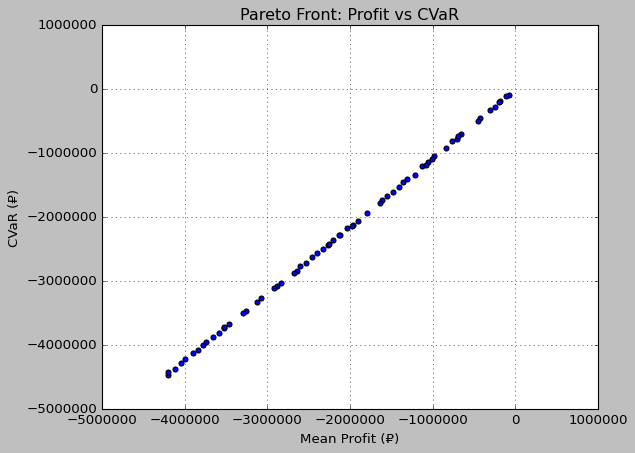

In [54]:
plt.scatter(-pareto_F[:,0], pareto_F[:,1])
plt.xlabel('Mean Profit (₽)')
plt.ylabel('CVaR (₽)')
plt.title('Pareto Front: Profit vs CVaR')
plt.grid(True)
plt.show()

In [ ]:
mydf = agg.copy()
COST_PER_GB = 0.025         
PRICE_PER_GB_MONTH = 0.010  
N_SIM = 100                 
ALPHA = 0.95      
DOWNTIME_COST_PER_HOUR = 500          
PLANNED_REPLACEMENT_DURATION_HR = 0.5
UNPLANNED_REPLACEMENT_DURATION_HR = 4
LEAD_TIME_DAYS = 3                    
INVENTORY_HOLDING_RATE_PER_30D = 0.01 
SIM_HORIZON_DAYS = 30

mydf["disk_cost"] = mydf["capacity_gb"] * COST_PER_GB
mydf["rev_cost"]  = mydf["capacity_gb"] * PRICE_PER_GB_MONTH

display(mydf)

,cost_mean,cost_std,capacity_gb,p_fail,disk_cost,rev_cost
model,,,,,,
CT250MX500SSD1,509.382204,25.469110,250.059350,1.034029e-03,6.251484,2.500594
HGST HMS5C4040ALE640,581.988677,29.099434,4000.787030,1.001347e-05,100.019676,40.007870
HGST HMS5C4040BLE640,547.114973,27.355749,4000.787030,7.167810e-06,100.019676,40.007870
HGST HUH721212ALE600,566.038361,28.301918,12000.138625,4.742400e-06,300.003466,120.001386
HGST HUH721212ALE604,526.814392,26.340720,12000.138625,1.158559e-04,300.003466,120.001386
HGST HUH721212ALN604,553.375869,27.668793,12000.138625,1.403564e-04,300.003466,120.001386
HGST HUH728080ALE600,560.798351,28.039918,8001.563222,9.266148e-06,200.039081,80.015632
HGST HUH728080ALE604,583.728540,29.186427,8001.563222,6.900983e-07,200.039081,80.015632
MTFDDAV240TCB,525.245823,26.262291,240.057410,8.981929e-06,6.001435,2.400574


## Функция Монте‑Карло

In [117]:
def simulate_run(df, threshold, n_spares):
    inventory = n_spares
    cost = 0.0

    # Плановая замена
    planned = df[df['p_fail'] > threshold]
    unplanned = df[df['p_fail'] <= threshold]
    num_planned = len(planned)

    # Расход запасов
    if num_planned > inventory:
        shortage = num_planned - inventory
        inventory = 0
        cost += planned['disk_cost'].mean() * shortage  # закупка срочно
    else:
        inventory -= num_planned

    cost += planned['disk_cost'].sum()
    cost += num_planned * PLANNED_REPLACEMENT_DURATION_HR * DOWNTIME_COST_PER_HOUR

    # Случайные отказы
    failed_mask = (np.random.rand(len(unplanned)) < unplanned['p_fail'].values * 100)
    failed = unplanned[failed_mask]
    num_failed = len(failed)

    # Запасы на отказы
    if num_failed > inventory:
        covered = inventory
        shortage = num_failed - inventory
        inventory = 0
    else:
        covered = num_failed
        shortage = 0
        inventory -= num_failed

    # Стоимость при наличии запасов
    if covered:
        cost += failed.iloc[:covered]['disk_cost'].sum()
        cost += covered * UNPLANNED_REPLACEMENT_DURATION_HR * DOWNTIME_COST_PER_HOUR

    # Стоимость при дефиците
    if shortage:
        shortage_disks = failed.iloc[covered:]
        cost += shortage_disks['disk_cost'].sum()
        downtime_hours = LEAD_TIME_DAYS * 24 + UNPLANNED_REPLACEMENT_DURATION_HR
        cost += shortage * downtime_hours * DOWNTIME_COST_PER_HOUR

    # Хранение остатка
    cost += inventory * df['disk_cost'].mean() * INVENTORY_HOLDING_RATE_PER_30D

    revenue = -cost
    revenue += planned["capacity_gb"].sum() * PRICE_PER_GB_MONTH * SIM_HORIZON_DAYS / 30
    return revenue

In [130]:
# !pip install pymoo nbformat pandas numpy matplotlib
import pandas as pd
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer
from pymoo.termination import get_termination
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.optimize import minimize
import matplotlib.pyplot as plt

class DiskProblem(Problem):
    def __init__(self, df):
        super().__init__(n_var=2, n_obj=2, n_constr=0,
                         xl=np.array([0.0, 0.0]), xu=np.array([1.0, 50.0]))
        self.df = df

    def _evaluate(self, X, out, *args, **kwargs):
        # X shape: (n_solutions, 2) -> [threshold, spares]
        F = np.zeros((X.shape[0], 2))
        for i, (thr, sp) in enumerate(X):
            sp_int = int(round(sp))
            revenues = np.array([simulate_run(self.df, thr, sp_int)
                                 for _ in range(N_SIM)])
            mean_rev = revenues.mean()
            var95 = np.quantile(-revenues, 0.05)
            cvar = -revenues[-revenues <= var95].mean()
            F[i, 0] = mean_rev
            F[i, 1] = -cvar
        out['F'] = F

In [131]:
def cvar_95(sample, alpha=ALPHA):
    """Compute CVaR (Expected Shortfall) at confidence level `alpha`."""
    cutoff = np.quantile(sample, 1 - alpha)
    return sample[sample <= cutoff].mean()  # lower tail average


In [138]:
problem = DiskProblem(mydf)

algorithm = NSGA2(
    pop_size=320,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=20),
    mutation=PM(eta=25),
    eliminate_duplicates=False
)

res = minimize(
    problem,
    algorithm,
    get_termination("n_gen", 60),
    seed=1,
    save_history=True,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      320 |      8 |             - |             -
     2 |      640 |      9 |  0.1103662041 |         ideal
     3 |      960 |      4 |  0.3177833321 |         ideal
     4 |     1280 |      4 |  0.3262404475 |         ideal
     5 |     1600 |      3 |  0.7345813127 |         ideal
     6 |     1920 |      4 |  0.0045281525 |             f
     7 |     2240 |      7 |  0.0257189244 |             f
     8 |     2560 |      2 |  0.2178344711 |         ideal
     9 |     2880 |      2 |  0.0781340198 |         ideal
    10 |     3200 |      2 |  0.2666244405 |         ideal
    11 |     3520 |      2 |  0.0076351531 |         ideal
    12 |     3840 |      2 |  0.0075772992 |         ideal
    13 |     4160 |      6 |  0.000000E+00 |             f
    14 |     4480 |     16 |  0.000000E+00 |             f
    15 |     4800 |     33 |  0.000000E+00 |             f
    16 |     5120 |     70 |  0.000000E+00 |            

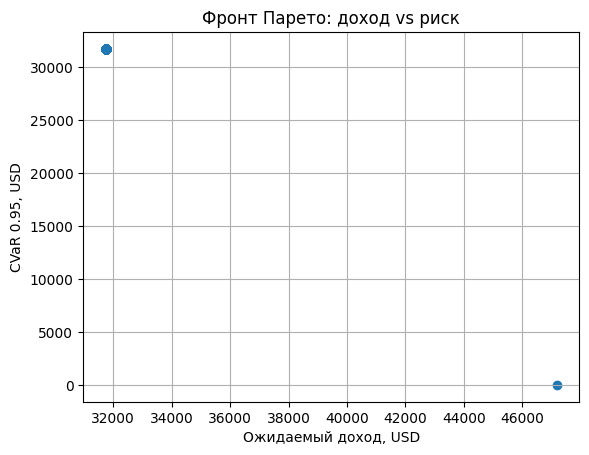

In [140]:
F = res.F
plt.scatter(-F[:,0], -F[:,1])
plt.xlabel('Ожидаемый доход, USD')
plt.ylabel('CVaR 0.95, USD')
plt.title('Фронт Парето: доход vs риск')
plt.grid(True)
plt.show()